<a href="https://colab.research.google.com/github/michelucci/TF20-Notes/blob/master/TF2_0_notes_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

TensorFlow 2.x selected.


In [0]:
from tensorflow import keras
from tensorflow.keras import layers

# References

https://www.tensorflow.org/beta/guide/keras/training_and_evaluation


# Model specification

In [0]:
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Data preparation

In [4]:
# Load a toy dataset for the sake of this example
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are Numpy arrays)
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

11493376/11490434 [==============================] - 0s 0us/step


# model compilation

In [0]:
# Specify the training configuration (optimizer, loss, metrics)
model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[keras.metrics.SparseCategoricalAccuracy()])


# Model Fit

In [0]:
# Train the model by slicing the data into "batches"
# of size "batch_size", and repeatedly iterating over
# the entire dataset for a given number of "epochs"
print('# Fit model on training data')
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=3,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(x_val, y_val))

# Fit model on training data
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 76us/sample - loss: 0.3372 - sparse_categorical_accuracy: 0.9029 - val_loss: 0.1643 - val_sparse_categorical_accuracy: 0.9543
Epoch 2/3
50000/50000 [==============================] - 3s 53us/sample - loss: 0.1572 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.1309 - val_sparse_categorical_accuracy: 0.9610
Epoch 3/3
50000/50000 [==============================] - 3s 53us/sample - loss: 0.1163 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1120 - val_sparse_categorical_accuracy: 0.9668


In [0]:
print('\nhistory dict:', history.history)


history dict: {'loss': [0.33721102640628814, 0.15723644578456877, 0.11631603244751691], 'sparse_categorical_accuracy': [0.9029, 0.95392, 0.96512], 'val_loss': [0.1642722847431898, 0.13087918029800058, 0.11199829497933388], 'val_sparse_categorical_accuracy': [0.9543, 0.961, 0.9668]}


In [0]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
10000/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)


# Generate predictions for 3 samples
predictions shape: (3, 10)


# Better job with functions

## Let's create some functions

In [0]:
def get_uncompiled_model():
  inputs = keras.Input(shape=(784,), name='digits')
  x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

def get_compiled_model():
  model = get_uncompiled_model()
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
  return model

Many built-in optimizers, losses, and metrics are available
In general, you won't have to create from scratch your own losses, metrics, or optimizers, because what you need is likely already part of the Keras API:

Optimizers: - ```SGD()``` (with or without momentum) - ```RMSprop()``` - ```Adam()``` - etc.

Losses: - ```MeanSquaredError()``` - ```KLDivergence()``` - ```CosineSimilarity(```) - etc.

Metrics: - ```AUC()``` - ```Precision()``` - ```Recall()``` - etc.

## Custom losses
There are two ways to provide custom losses with Keras. The first example creates a function that accepts inputs y_true and y_pred. The following example shows a loss function that computes the average distance between the real data and the predictions:

In [0]:
def basic_loss_function(y_true, y_pred):
    return tf.math.reduce_mean(y_true - y_pred)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=basic_loss_function)

model.fit(x_train, y_train, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 48us/sample - loss: 4.3488
Epoch 2/3
50000/50000 [==============================] - 2s 42us/sample - loss: 4.3488
Epoch 3/3
50000/50000 [==============================] - 2s 42us/sample - loss: 4.3488


## Custom metrics

If you need a metric that isn't part of the API, you can easily create custom metrics by subclassing the ```Metric``` class. You will need to implement 4 methods:

- ```__init__(self)```, in which you will create state variables for your metric.

- ```update_state(self, y_true, y_pred, sample_weight=None)```, which uses the targets y_true and the model predictions y_pred to update the state variables.

- ```result(self)```, which uses the state variables to compute the final results.

- ```reset_states(self)```, which reinitializes the state of the metric.

State update and results computation are kept separate (in ```update_state(```) and ```result()v, respectively) because in some cases, results computation might be very expensive, and would only be done periodically.

Here's a simple example showing how to implement a ```CatgoricalTruePositives``` metric, that counts how many samples where correctly classified as belonging to a given class:

In [0]:
class CatgoricalTruePositives(keras.metrics.Metric):

    def __init__(self, name='categorical_true_positives', **kwargs):
      super(CatgoricalTruePositives, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
      values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
      values = tf.cast(values, 'float32')
      if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, 'float32')
        values = tf.multiply(values, sample_weight)
      self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
      return self.true_positives

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(0.)


model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[CatgoricalTruePositives()])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 3s 57us/sample - loss: 0.0926 - categorical_true_positives: 48569.0000
Epoch 2/3
50000/50000 [==============================] - 2s 48us/sample - loss: 0.0757 - categorical_true_positives: 48860.0000
Epoch 3/3
50000/50000 [==============================] - 2s 48us/sample - loss: 0.0651 - categorical_true_positives: 48966.0000


# Automatically setting up a validation holdout set

Automatically setting apart a validation holdout set
In the first end-to-end example you saw, we used the ```validation_data``` argument to pass a tuple of Numpy arrays ```(x_val, y_val)``` to the model for evaluating a validation loss and validation metrics at the end of each epoch.

Here's another option: the argument ```validation_split``` allows you to automatically reserve part of your training data for validation. The argument value represents the fraction of the data to be reserved for validation, so it should be set to a number higher than 0 and lower than 1. For instance, ```validation_split=0.2``` means "use 20% of the data for validation", and ```validation_split=0.6``` means "use 60% of the data for validation".

The way the validation is computed is by taking the last x% samples of the arrays received by the fit call, before any shuffling.

You can only use ```validation_split``` when training with Numpy data.

In [0]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=3)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 3s 68us/sample - loss: 0.3807 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.2477 - val_sparse_categorical_accuracy: 0.9270
Epoch 2/3
40000/40000 [==============================] - 2s 52us/sample - loss: 0.1848 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.1753 - val_sparse_categorical_accuracy: 0.9476
Epoch 3/3
40000/40000 [==============================] - 2s 53us/sample - loss: 0.1326 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.1598 - val_sparse_categorical_accuracy: 0.9522


# Using ```tf.data.Datasets```

In [0]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print('\n# Evaluate')
model.evaluate(test_dataset)

Epoch 1/3
782/782 [==============================] - 6s 7ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.9048
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9536
Epoch 3/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1153 - sparse_categorical_accuracy: 0.9652

# Evaluate
157/157 [==============================] - 0s 2ms/step - loss: 0.1217 - sparse_categorical_accuracy: 0.9625


[0.1216799323246844, 0.9625]

If you want to run training only on a specific number of batches from this Dataset, you can pass the ```steps_per_epoch argument```, which specifies how many training steps the model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep drawing the next batches. The dataset will eventually run out of data (unless it is an infinitely-looping dataset).

In [0]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset.take(100), epochs=3)

Epoch 1/3
100/100 [==============================] - 1s 13ms/step - loss: 0.7970 - sparse_categorical_accuracy: 0.7989
Epoch 2/3
100/100 [==============================] - 0s 5ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.9069
Epoch 3/3
100/100 [==============================] - 0s 5ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.9253


## Explanation of the ```buffer_size``` parameter in ```shuffle()```

By contrast, the ```buffer_size``` argument to ```tf.data.Dataset.shuffle()``` affects the randomness of the transformation. We designed the ```Dataset.shuffle()``` transformation (like the ```tf.train.shuffle_batch()``` function that it replaces) to handle datasets that are too large to fit in memory. Instead of shuffling the entire dataset, it maintains a buffer of ```buffer_size``` elements, and randomly selects the next element from that buffer (replacing it with the next input element, if one is available). Changing the value of ```buffer_size``` affects how uniform the shuffling is: if ```buffer_size``` is greater than the number of elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all. For very large datasets, a typical "good enough" approach is to randomly shard the data into multiple files once before training, then shuffle the filenames uniformly, and then use a smaller shuffle buffer. However, the appropriate choice will depend on the exact nature of your training job.

From: https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

## Validation set

In [0]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
782/782 [==============================] - 6s 7ms/step - loss: 0.3295 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.1390 - val_sparse_categorical_accuracy: 0.9617
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1188 - val_sparse_categorical_accuracy: 0.9647


At the end of each epoch, the model will iterate over the validation Dataset and compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this Dataset, you can pass the ```validation_steps``` argument, which specifies how many validation steps the model should run with the validation Dataset before interrupting validation and moving on to the next epoch:

In [0]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3,
          # Only run validation using the first 10 batches of the dataset
          # using the `validation_steps` argument
          validation_data=val_dataset, validation_steps=10)

Epoch 1/3
782/782 [==============================] - 6s 7ms/step - loss: 0.3389 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1581 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.2267 - val_sparse_categorical_accuracy: 0.9375
Epoch 3/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1149 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.1594 - val_sparse_categorical_accuracy: 0.9531


# Passing data to multi-input, multi-output models

In the previous examples, we were considering a model with a single input (a tensor of shape ```(764,)```) and a single output (a prediction tensor of shape```(10,)```). But what about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape ```(32, 32, 3)``` (that's ```(height, width, channels)```) and a timeseries input of shape ```(None, 10)``` (that's ```(timesteps, features)```). Our model will have two outputs computed from the combination of these inputs: a "score" (of shape ```(1,)```) and a probability distribution over 5 classes (of shape ```(10,)```).

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

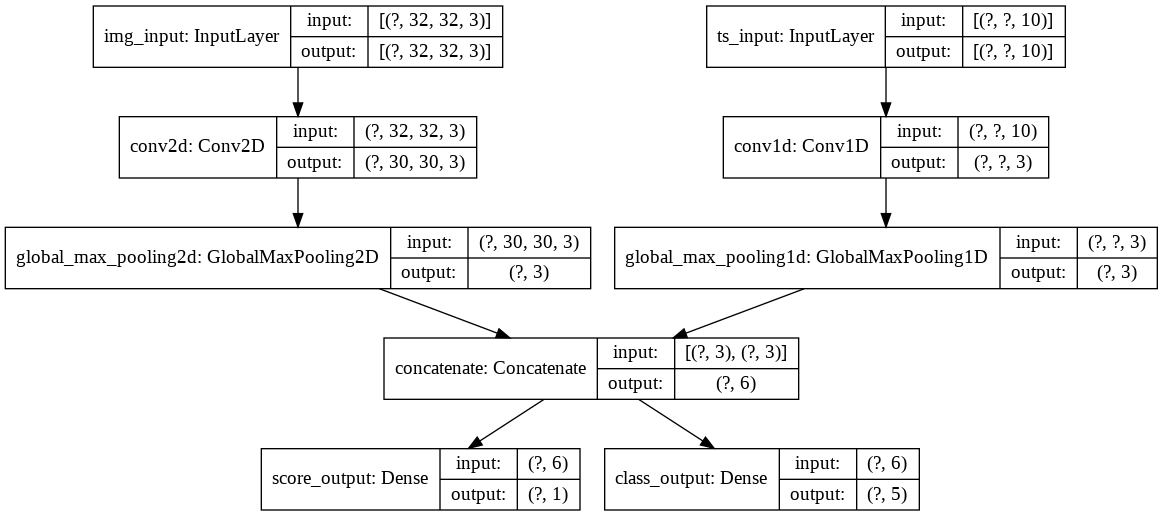

In [0]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

If we only passed a single loss function to the model, the same loss function would be applied to every output, which is not appropriate here.

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]})

You could also chose not to compute a loss for certain outputs, if these outputs meant for prediction but not for training:

In [0]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})

In [0]:
import numpy as np

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# Generate dummy Numpy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)

# Alernatively, fit on dicts
model.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
          epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 1s 9ms/sample - loss: 5.4007 - score_output_loss: 0.7716 - class_output_loss: 4.3417
Epoch 2/3
100/100 [==============================] - 0s 573us/sample - loss: 5.0339 - score_output_loss: 0.4582 - class_output_loss: 4.4898
Epoch 3/3
100/100 [==============================] - 0s 522us/sample - loss: 4.8682 - score_output_loss: 0.3535 - class_output_loss: 4.3451
Train on 100 samples
Epoch 1/3
100/100 [==============================] - 0s 655us/sample - loss: 4.7594 - score_output_loss: 0.2209 - class_output_loss: 4.6201
Epoch 2/3
100/100 [==============================] - 0s 518us/sample - loss: 4.7109 - score_output_loss: 0.1794 - class_output_loss: 4.4980
Epoch 3/3
100/100 [==============================] - 0s 527us/sample - loss: 4.6708 - score_output_loss: 0.1501 - class_output_loss: 4.6839


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'img_input': img_data, 'ts_input': ts_data},
     {'score_output': score_targets, 'class_output': class_targets}))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=3)

Epoch 1/3
2/2 [==============================] - 1s 326ms/step - loss: 4.6314 - score_output_loss: 0.1546 - class_output_loss: 4.4768
Epoch 2/3
2/2 [==============================] - 0s 32ms/step - loss: 4.6047 - score_output_loss: 0.1375 - class_output_loss: 4.5333
Epoch 3/3
2/2 [==============================] - 0s 31ms/step - loss: 4.6573 - score_output_loss: 0.1184 - class_output_loss: 4.5021


# Callbacks classes

Examples of why one would need to use callbacks classes

- Doing validation at different points during training (beyond the built-in per-epoch validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
- Etc.

## Early stopping callback examples

In [0]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 3s 65us/sample - loss: 0.3676 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2194 - val_sparse_categorical_accuracy: 0.9346
Epoch 2/20
40000/40000 [==============================] - 2s 58us/sample - loss: 0.1722 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.1766 - val_sparse_categorical_accuracy: 0.9462
Epoch 3/20
40000/40000 [==============================] - 2s 59us/sample - loss: 0.1232 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.1644 - val_sparse_categorical_accuracy: 0.9507
Epoch 4/20
40000/40000 [==============================] - 2s 60us/sample - loss: 0.0971 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.1390 - val_sparse_categorical_accuracy: 0.9591
Epoch 5/20
40000/40000 [==============================] - 2s 53us/sample - loss: 0.0799 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.1316 - val_sparse_categorical_accuracy: 0.9631
Epoch 6/20
4000

## Types of callbacks



- ```ModelCheckpoint```: Periodically save the model.
- ```EarlyStopping```: Stop training when training is no longer improving the validation metrics.
- ```TensorBoard```: periodically write model logs that can be visualized in TensorBoard (more details in the section "Visualization").
- ```CSVLogger```: streams loss and metrics data to a CSV file.
- etc.

## Custom callbacks

You can create a custom callback by extending the base class ```keras.callbacks.Callback```. A callback has access to its associated model through the class property ```self.model```.

In [0]:
class LossHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs):
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))

## Checkpointing callbacks

In [0]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
39872/40000 [============================>.] - ETA: 0s - loss: 0.3746 - sparse_categorical_accuracy: 0.8938
Epoch 00001: val_loss improved from inf to 0.24213, saving model to mymodel_1.h5
40000/40000 [==============================] - 3s 68us/sample - loss: 0.3744 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.2421 - val_sparse_categorical_accuracy: 0.9273
Epoch 2/3
39168/40000 [============================>.] - ETA: 0s - loss: 0.1758 - sparse_categorical_accuracy: 0.9473
Epoch 00002: val_loss improved from 0.24213 to 0.18390, saving model to mymodel_2.h5
40000/40000 [==============================] - 2s 57us/sample - loss: 0.1764 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.1839 - val_sparse_categorical_accuracy: 0.9420
Epoch 3/3
39872/40000 [============================>.] - ETA: 0s - loss: 0.1284 - sparse_categorical_accuracy: 0.9622
Epoch 00003: val_loss improved from 0.18390 to 0.15560, saving model to mymode

In [0]:
!ls

multi_input_and_output_model.png  mymodel_2.h5	sample_data
mymodel_1.h5			  mymodel_3.h5


# Learning rate decay methods

A common pattern when training deep learning models is to gradually reduce the learning as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the current epoch or the current batch index), or dynamic (responding to the current behavior of the model, in particular the validation loss).

Passing a schedule to an optimizer
You can easily use a static learning rate decay schedule by passing a schedule object as the learning_rate argument in your optimizer:

In [0]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

## Main types of schedules

Several built-in schedules are available: ```ExponentialDecay```, ```PiecewiseConstantDecay```, ```PolynomialDecay```, and ```InverseTimeDecay```.

## Using callbacks and learning rate decay

Using callbacks to implement a dynamic learning rate schedule
A dynamic learning rate schedule (for instance, decreasing the learning rate when the validation loss is no longer improving) cannot be achieved with these schedule objects since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can thus achieve this pattern by using a callback that modifies the current learning rate on the optimizer. In fact, this is even built-in as the ReduceLROnPlateau callback.

# My own Training (GradientTape)

Here is an example on how to build your own training loop completely from scratch.

In [0]:
# Get the model.
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

In [0]:
# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

Now we iterate over epochs

In [7]:
# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape() as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      logits = model(x_batch_train)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss_value = loss_fn(y_batch_train, logits)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training loss (for one batch) at step 0: 2.291839599609375
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.242462158203125
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.1596622467041016
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.1509897708892822
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 1.9326403141021729
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9350440502166748
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.8397014141082764
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7012557983398438
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 1.6696522235870361
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.647040605545044
Seen so fa

## Using ```metrics``` in self-developed loops

In [0]:
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)



In [17]:

# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Update training metric.
    train_acc_metric(y_batch_train, logits)

    # Log every 200 batches.
    #if step % 200 == 0:
    #    print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
    #    print('Seen so far: %s samples' % ((step + 1) * 64))

  # Display metrics at the end of each epoch.
  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))
  # Reset training metrics at the end of each epoch
  train_acc_metric.reset_states()

  # Run a validation loop at the end of each epoch.
  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training acc over epoch: 0.7538999915122986
Validation acc: 0.805400013923645
Start of epoch 1
Training acc over epoch: 0.7954400181770325
Validation acc: 0.8337000012397766
Start of epoch 2
Training acc over epoch: 0.8209599852561951
Validation acc: 0.8507999777793884
